In [1]:
# Uncomment to install/upgrade ras-commander from pip
#!pip install --upgrade ras-commander

#Import the ras-commander package
from ras_commander import *

##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *


# Dam Breach Results Extraction and Sensitivity Analysis

This notebook demonstrates:
1. **Extracting baseline breach results** from HDF files
2. **Reading breach parameters** from plan files
3. **Modifying parameters iteratively** (one parameter at a time)
4. **Comparing results** across different scenarios
5. **Visualizing sensitivity** to parameter changes

**Project:** BaldEagleCrkMulti2D (HEC-RAS Example)  
**Baseline Plan:** 02  
**Version:** 6.6

**Workflow:**
- Extract baseline results
- Clone plan and modify one parameter
- Re-extract results and compare
- Repeat for multiple parameters
- Plot all scenarios together

## Setup and Imports

In [2]:
# Standard imports
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil

In [3]:
#! pip uninstall -y ras-commander

In [4]:
import os
import sys
current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent
sys.path.append(str(rascmdr_directory))
print("Loading ras-commander from local dev copy")

# Import RAS-Commander modules
from ras_commander import *

Loading ras-commander from local dev copy


In [5]:
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))
    
print("Loading ras-commander from local dev copy")

# Now try to import again
from ras_commander import *

# Verify we're loading from the local copy
import ras_commander
local_path = Path(ras_commander.__file__).parent.parent
print(f"ras-commander loaded from: {local_path}")
print(f"Expected local path: {rascmdr_directory}")
print(f"Successfully using local copy: {local_path == rascmdr_directory}")


Loading ras-commander from local dev copy
ras-commander loaded from: C:\GH\ras-commander
Expected local path: C:\GH\ras-commander
Successfully using local copy: True


## 1. Extract and Initialize Project

In [6]:
# Use existing folder if present, else extract
from pathlib import Path
example_project_folder = Path("c:/GH/ras-commander/examples/example_projects/BaldEagleCrkMulti2D")
if example_project_folder.exists():
    project_path = example_project_folder
    print(f"Project folder already exists: {project_path}")
else:
    project_path = RasExamples.extract_project("BaldEagleCrkMulti2D")
    print(f"Extracted project to: {project_path}")

Project folder already exists: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D


In [7]:
# Initialize the project
init_ras_project(project_path, "6.6")
print(f"\nInitialized project: {ras.project_name}")
print(f"\nAvailable plans:")
ras.plan_df

# This is the SA to 2D Dam Break Run
template_plan = "19"

2025-12-02 20:52:57 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap



Initialized project: BaldEagleDamBrk

Available plans:


### RasResultsBreach - Breach Results (HDF Files)
**Use for:** Extracting breach simulation RESULTS from HDF output files (.p##.hdf)

```python
from ras_commander import HdfResultsBreach

# Extract complete time series (flow, stage, breach geometry evolution)
timeseries = HdfResultsBreach.get_breach_timeseries("02", "Dam")

# Get summary statistics (peaks, timing, final geometry)
summary = HdfResultsBreach.get_breach_summary("02")

# Get breach-specific variables (width, depth, slopes over time)
breach_vars = HdfResultsBreach.get_breaching_variables("02", "Dam")
```

**Key Points:**
- ✅ Extracts results AFTER HEC-RAS has run
- ✅ Works with plan numbers or HDF file paths
- ✅ Requires .p##.hdf file to exist (created by HEC-RAS)
- ⚠️ Structure names in HDF may include prefixes (e.g., "BaldEagleCr Dam")

## 2. BASELINE: Extract Existing Results from Plan 02

First, extract and analyze the baseline breach behavior from the existing Plan 02 results.

### Important Note: HDF Results Files

**This example project may not include pre-computed HDF results** (.p02.hdf files). These files are generated when HEC-RAS runs a simulation.

**If you encounter "HDF file not found" errors:**
1. Option A: Run HEC-RAS simulation for Plan 02 first
2. Option B: Use the RasCmdr class to run simulation from Python (see cell below)
3. Option C: Use a different project with existing results (e.g., Scott County)

**The notebook will gracefully handle missing results and still demonstrate parameter modification.**

In [8]:
# Initialize variables to None (prevents NameError in later cells)
target_structure = None
baseline_ts = pd.DataFrame()
baseline_summary = pd.DataFrame()
baseline_params = None
baseline_geom = []
scenarios = {}
summaries = {}

### 2.1 Identify Breach Structures

In [9]:
# List breach structures from PLAN FILE (for parameter operations)
# This ensures structure names match between listing and read_breach_block()
try:
    breach_structures_list = RasBreach.list_breach_structures_plan(template_plan)
    
    print("Breach Structures in Plan File:")
    for struct in breach_structures_list:
        if struct['structure']:  # Filter empty names
            status = "ACTIVE" if struct['is_active'] else "INACTIVE"  
            location = f"{struct['river']}/{struct['reach']}/RS {struct['station']}" if struct['river'] else "No location"
            print(f"  - {struct['structure']}: {status} ({location})")
    
    # Get active structure names for parameter operations
    breach_structures = [s['structure'] for s in breach_structures_list 
                        if s['structure'] and s['is_active']]
    
    if breach_structures:
        target_structure = breach_structures[0]
        print(f"\nTarget structure for analysis: {target_structure}")
        print(f"  This name will work with RasBreach.read_breach_block()")
    else:
        print("\nWARNING: No active breach structures found!")
        target_structure = None

except Exception as e:
    print(f"Error listing breach structures: {e}")
    import traceback
    traceback.print_exc()
    target_structure = None
    breach_structures = []

2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Found 2 breach structures in BaldEagleDamBrk.p19


Breach Structures in Plan File:
  - Dam: ACTIVE (No location)

Target structure for analysis: Dam
  This name will work with RasBreach.read_breach_block()


if target_structure:
    try:
        # Extract complete breach time series from HDF results
        baseline_ts = HdfResultsBreach.get_breach_timeseries("02", target_structure)
        
        print(f"Baseline Time Series Extracted: {baseline_ts.shape}")
        print(f"\nColumns: {list(baseline_ts.columns)}")
        print(f"\nFirst few timesteps:")
        print(baseline_ts.head())
        
        # Get summary statistics from HDF results
        baseline_summary = HdfResultsBreach.get_breach_summary("02", target_structure)
        print(f"\nBaseline Summary Statistics:")
        print(baseline_summary.to_string(index=False))
        
        # Store baseline for later comparison
        scenarios = {
            'Baseline (Plan 02)': baseline_ts.copy()
        }
        summaries = {
            'Baseline (Plan 02)': baseline_summary.copy()
        }
    except Exception as e:
        print(f"Could not extract baseline time series: {e}")
        print("Continuing with parameter analysis only...")
        baseline_ts = pd.DataFrame()
        baseline_summary = pd.DataFrame()
        scenarios = {}
        summaries = {}
else:
    print("Skipping baseline extraction - no breach structure available")
    scenarios = {}
    summaries = {}

In [10]:
template_plan

'19'

In [11]:
# Read current parameters
params = RasBreach.read_breach_block(template_plan, "Dam")
geom = [x.strip() for x in params['values']['Breach Geom'].split(',')]

# Update Final Bottom Elevation (index 2)
geom[2] = 605  # New elevation in feet

# Write back
RasBreach.update_breach_block(template_plan, "Dam", geom_values=geom)

2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Read breach block for Dam from BaldEagleDamBrk.p19
2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Created backup: BaldEagleDamBrk_backup_20251202_205257.p19
2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Updated breach block for Dam in BaldEagleDamBrk.p19


{'structure_name': 'Dam',
 'is_active': True,
 'river': '',
 'reach': '',
 'station': '',
 'values': {'Breach Loc': '                ,                ,        ,True,Dam',
  'Breach Method': ' 0',
  'Breach Geom': '5700,200,605,0.5,0.5,True,0.5,630,2,2.6',
  'Breach Start': 'True,661,,,False,,,0',
  'Breach Progression': ' 2',
  'Simplified Physical Breach Downcutting': ' 2',
  'Simplified Physical Breach Widening': ' 2',
  'Starting Notch Depth': ' 3.402823E+38',
  'Initial Piping Diameter': ' 3.402823E+38',
  'Mass Wasting Options': ' 0',
  'Mass Wasting Width': ' 3.402823E+38',
  'Mass Wasting Duration': ' 3.402823E+38',
  'Mass Wasting Final Bottom Elevation': ' 3.402823E+38',
  'Breach Use User Defined Growth Ratio': '-1',
  'Breach User Defined Growth Ratio': '1'},
 'table_rows': {'Breach Progression': [[0.0, 0.0, 1.0, 1.0]],
  'Simplified Physical Breach Downcutting': [[0.0, 0.0, 1.0, 1.0]],
  'Simplified Physical Breach Widening': [[0.0, 0.0, 1.0, 1.0]]}}

In [12]:
if target_structure:
    try:
        # Read breach parameters from plan file
        baseline_params = RasBreach.read_breach_block("02", target_structure)
        
        print(f"Baseline Parameters for {target_structure}:")
        print("=" * 80)
        print(f"\nActivation: {baseline_params['is_active']}")
        print(f"\nKey Parameter Values:")
        for key in ['Breach Method', 'Breach Geom', 'Breach Start', 'Breach Progression']:
            if key in baseline_params['values']:
                print(f"  {key}: {baseline_params['values'][key]}")
        
        # Parse geometry values for modification
        geom_str = baseline_params['values'].get('Breach Geom', '')
        baseline_geom = [x.strip() for x in geom_str.split(',') if x.strip()]
        print(f"\nBaseline Geometry (parsed): {baseline_geom}")
        
        # Explain Breach Geom field structure
        if len(baseline_geom) >= 10:
            print("\nBreach Geom Field Structure (CSV, 10 fields):")
            print(f"  [0] Centerline/Station: {baseline_geom[0]} ft")
            print(f"  [1] Initial Bottom Width: {baseline_geom[1]} ft")
            print(f"  [2] Final Bottom Elevation: {baseline_geom[2]} ft  <-- KEY PARAMETER")
            print(f"  [3] Left Side Slope: {baseline_geom[3]} (H:V)")
            print(f"  [4] Right Side Slope: {baseline_geom[4]} (H:V)")
            print(f"  [5] Active Flag: {baseline_geom[5]}")
            print(f"  [6] Weir Coefficient: {baseline_geom[6]}")
            print(f"  [7] Top Elevation: {baseline_geom[7]} ft")
            print(f"  [8] Formation Method: {baseline_geom[8]} (1=Time, 2=Trigger)")
            print(f"  [9] Formation Time/Threshold: {baseline_geom[9]} hrs or ft")
            
            print("\n--- Example: Update Final Bottom Elevation ---")
            print(f"Current value: {baseline_geom[2]} ft")
            print("To change to 605 ft:")
            print("  new_geom = baseline_geom.copy()")
            print("  new_geom[2] = 605")
            print('  RasBreach.update_breach_block("template_plan", "Dam", geom_values=new_geom)')
            
    except Exception as e:
        print(f"Could not read baseline parameters: {e}")
        baseline_params = None
        baseline_geom = []
else:
    print("Skipping parameter reading - no breach structure available")
    baseline_params = None
    baseline_geom = []

2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Read breach block for Dam from BaldEagleDamBrk.p02


Baseline Parameters for Dam:

Activation: True

Key Parameter Values:
  Breach Method:  0
  Breach Geom: 5722,200,595,0.5,0.5,True,0.5,630,3.2,2.6
  Breach Start: True,676,,,False,,,0
  Breach Progression:  21

Baseline Geometry (parsed): ['5722', '200', '595', '0.5', '0.5', 'True', '0.5', '630', '3.2', '2.6']

Breach Geom Field Structure (CSV, 10 fields):
  [0] Centerline/Station: 5722 ft
  [1] Initial Bottom Width: 200 ft
  [2] Final Bottom Elevation: 595 ft  <-- KEY PARAMETER
  [3] Left Side Slope: 0.5 (H:V)
  [4] Right Side Slope: 0.5 (H:V)
  [5] Active Flag: True
  [6] Weir Coefficient: 0.5
  [7] Top Elevation: 630 ft
  [8] Formation Method: 3.2 (1=Time, 2=Trigger)
  [9] Formation Time/Threshold: 2.6 hrs or ft

--- Example: Update Final Bottom Elevation ---
Current value: 595 ft
To change to 605 ft:
  new_geom = baseline_geom.copy()
  new_geom[2] = 605
  RasBreach.update_breach_block("template_plan", "Dam", geom_values=new_geom)


In [13]:
if target_structure:
    try:
        # Extract complete breach time series from HDF results
        baseline_ts = HdfResultsBreach.get_breach_timeseries(template_plan, target_structure)
        
        print(f"Baseline Time Series Extracted: {baseline_ts.shape}")
        print(f"\nColumns: {list(baseline_ts.columns)}")
        print(f"\nFirst few timesteps:")
        print(baseline_ts.head())
        
        # Get summary statistics from HDF results
        baseline_summary = HdfResultsBreach.get_breach_summary(template_plan, target_structure)
        print(f"\nBaseline Summary Statistics:")
        print(baseline_summary.to_string(index=False))
        
        # Store baseline for later comparison
        scenarios = {
            f'Baseline (Plan {template_plan})': baseline_ts.copy()
        }
        summaries = {
            f'Baseline (Plan {template_plan})': baseline_summary.copy()
        }
    except Exception as e:
        print(f"Could not extract baseline time series: {e}")
        print("Continuing with parameter analysis only...")
        baseline_ts = pd.DataFrame()
        baseline_summary = pd.DataFrame()
        scenarios = {}
        summaries = {}
else:
    print("Skipping baseline extraction - no breach structure available")
    scenarios = {}
    summaries = {}

2025-12-02 20:52:57 - ras_commander.hdf.HdfResultsBreach - ERROR - HDF file not found: 19


Could not extract baseline time series: HDF file not found: 19
Continuing with parameter analysis only...


In [14]:
if target_structure:
    try:
        # Extract complete breach time series
        baseline_ts = HdfResultsBreach.get_breach_timeseries(template_plan, target_structure)
        
        print(f"Baseline Time Series Extracted: {baseline_ts.shape}")
        print(f"\nColumns: {list(baseline_ts.columns)}")
        print(f"\nFirst few timesteps:")
        print(baseline_ts.head())
        
        # Get summary statistics
        baseline_summary = HdfResultsBreach.get_breach_summary(template_plan, target_structure)
        print(f"\nBaseline Summary Statistics:")
        print(baseline_summary.to_string(index=False))
        
        # Store baseline for later comparison
        scenarios = {
            f'Baseline (Plan {template_plan})': baseline_ts.copy()
        }
        summaries = {
            f'Baseline (Plan {template_plan})': baseline_summary.copy()
        }
    except Exception as e:
        print(f"Could not extract baseline time series: {e}")
        print("Continuing with parameter analysis only...")
        baseline_ts = pd.DataFrame()
        baseline_summary = pd.DataFrame()
        scenarios = {}
        summaries = {}
else:
    print("Skipping baseline extraction - no breach structure available")
    scenarios = {}
    summaries = {}

2025-12-02 20:52:57 - ras_commander.hdf.HdfResultsBreach - ERROR - HDF file not found: 19


Could not extract baseline time series: HDF file not found: 19
Continuing with parameter analysis only...


### 2.3 Read Baseline Parameters

In [15]:
# List breach structures from plan file (for parameter operations)
try:
    breach_structures_list = RasBreach.list_breach_structures_plan(template_plan)

    print("Breach Structures in Plan File:")
    for struct in breach_structures_list:
        if struct['structure']:  # Filter empty names
            status = "ACTIVE" if struct['is_active'] else "INACTIVE"
            print(f"  - {struct['structure']}: {status}")

    # Get active structure names
    breach_structures = [s['structure'] for s in breach_structures_list
                        if s['structure'] and s['is_active']]

    if breach_structures:
        target_structure = breach_structures[0]
        print(f"\nTarget structure for analysis: {target_structure}")
    else:
        target_structure = None

except Exception as e:
    print(f"Error listing breach structures: {e}")
    target_structure = None


2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Found 2 breach structures in BaldEagleDamBrk.p19


Breach Structures in Plan File:
  - Dam: ACTIVE

Target structure for analysis: Dam


### Easy Parameter Modification with set_breach_geom()

**NEW FUNCTION:** `RasBreach.set_breach_geom()` provides a clean interface for modifying individual breach parameters without manually parsing/reconstructing the CSV.

In [16]:
# Example: Update just Final Bottom Elevation (most common modification)
if target_structure:
    print("Example: Update Final Bottom Elevation to 605 ft")
    print("=" * 60)
    print("\nSimple approach using set_breach_geom():")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            final_bottom_elev=605)")
    print("\nThis automatically:")
    print("  1. Reads current Breach Geom values")
    print("  2. Updates ONLY the final_bottom_elev field (index 2)")
    print("  3. Preserves all other parameters")
    print("  4. Writes back to plan file with backup")
    
    print("\n\nOther common modifications:")
    print("\n# Increase breach width by 50%")
    print("  current_width = 200  # Read from baseline_params")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            initial_width=current_width * 1.5)")
    
    print("\n# Change formation time")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            formation_time=3.5)")
    
    print("\n# Update multiple parameters at once")
    print("  RasBreach.set_breach_geom('template_plan', 'Dam',")
    print("                            final_bottom_elev=605,")
    print("                            initial_width=250,")
    print("                            formation_time=3.0)")
else:
    print("No target structure available for examples")

Example: Update Final Bottom Elevation to 605 ft

Simple approach using set_breach_geom():
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            final_bottom_elev=605)

This automatically:
  1. Reads current Breach Geom values
  2. Updates ONLY the final_bottom_elev field (index 2)
  3. Preserves all other parameters
  4. Writes back to plan file with backup


Other common modifications:

# Increase breach width by 50%
  current_width = 200  # Read from baseline_params
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            initial_width=current_width * 1.5)

# Change formation time
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            formation_time=3.5)

# Update multiple parameters at once
  RasBreach.set_breach_geom('template_plan', 'Dam',
                            final_bottom_elev=605,
                            initial_width=250,
                            formation_time=3.0)


In [17]:
if target_structure:
    try:
        # Read breach parameters from plan file
        baseline_params = RasBreach.read_breach_block(template_plan, target_structure)
        
        print(f"Baseline Parameters for {target_structure}:")
        print("=" * 80)
        print(f"\nActivation: {baseline_params['is_active']}")
        print(f"\nKey Parameter Values:")
        for key in ['Breach Method', 'Breach Geom', 'Breach Start', 'Breach Progression']:
            if key in baseline_params['values']:
                print(f"  {key}: {baseline_params['values'][key]}")
        
        # Parse geometry values for modification
        geom_str = baseline_params['values'].get('Breach Geom', '')
        baseline_geom = [x.strip() for x in geom_str.split(',') if x.strip()]
        print(f"\nBaseline Geometry (parsed): {baseline_geom}")
    except Exception as e:
        print(f"Could not read baseline parameters: {e}")
        baseline_params = None
        baseline_geom = []
else:
    print("Skipping parameter reading - no breach structure available")
    baseline_params = None
    baseline_geom = []

2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Read breach block for Dam from BaldEagleDamBrk.p19


Baseline Parameters for Dam:

Activation: True

Key Parameter Values:
  Breach Method:  0
  Breach Geom: 5700,200,605,0.5,0.5,True,0.5,630,2,2.6
  Breach Start: True,661,,,False,,,0
  Breach Progression:  2

Baseline Geometry (parsed): ['5700', '200', '605', '0.5', '0.5', 'True', '0.5', '630', '2', '2.6']


## 3. SCENARIO ANALYSIS: Modify Parameters and Compare Results

Now we'll create multiple scenarios by modifying breach parameters one at a time.

**Workflow for each scenario:**
1. Clone Plan 02 to a new plan number
2. Modify ONE parameter in the cloned plan
3. **[User must run HEC-RAS simulation]**
4. Extract results from the new plan
5. Compare with baseline

**Note:** This notebook demonstrates steps 1-2 and 4-5. You must run HEC-RAS (step 3) separately.

-----

### Scenario 1: Increase Breach Width by 50%

In [18]:
if target_structure and baseline_geom and len(baseline_geom) >= 2:
    # Clone plan
    scenario_1_plan = RasPlan.clone_plan(template_plan, "Scenario 1: +50% Width")
    
    # Modify breach width (assuming index 1 is width)
    try:
        new_geom = baseline_geom.copy()
        original_width = float(baseline_geom[1])
        new_width = original_width * 1.5
        new_geom[1] = new_width
        
        print(f"\nModifying breach width:")
        print(f"  Original: {original_width} ft")
        print(f"  New: {new_width} ft (+50%)")
        
        # Update the plan
        RasBreach.update_breach_block(
            scenario_1_plan,
            target_structure,
            geom_values=new_geom
        )
        
        print(f"\n✓ Scenario 1 plan created: {scenario_1_plan}")
        print(f"  Next step: Run HEC-RAS simulation for plan {scenario_1_plan}")
    except (ValueError, IndexError) as e:
        print(f"Could not parse geometry values: {e}")
else:
    print("Skipping Scenario 1 - insufficient baseline data")

2025-12-02 20:52:57 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p19 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07
2025-12-02 20:52:57 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p07
2025-12-02 20:52:57 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07
2025-12-02 20:52:57 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap
2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Created backup: BaldEagleDamBrk_backup_20251202_205257.p07
2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Updated breach block for Dam in BaldEagleDamBrk.p07



Modifying breach width:
  Original: 200.0 ft
  New: 300.0 ft (+50%)

✓ Scenario 1 plan created: 07
  Next step: Run HEC-RAS simulation for plan 07


if target_structure:
    # Scenario definitions
    scenario_plans = {
        'Scenario 1: +50% Width': '03',
        'Scenario 2: -50% Formation Time': '04',
        'Scenario 3: Different Method': '05'
    }
    
    # Try to extract results for each scenario from HDF files
    for scenario_name, plan_num in scenario_plans.items():
        try:
            # Extract breach results from HDF using HdfResultsBreach
            ts = HdfResultsBreach.get_breach_timeseries(plan_num, target_structure)
            summary = HdfResultsBreach.get_breach_summary(plan_num, target_structure)
            
            if not ts.empty:
                scenarios[scenario_name] = ts
                summaries[scenario_name] = summary
                print(f"✓ Extracted: {scenario_name}")
            else:
                print(f"⚠ No results for: {scenario_name} (run HEC-RAS first)")
        except FileNotFoundError as e:
            print(f"⚠ HDF not found for {scenario_name}: Plan {plan_num} (run HEC-RAS first)")
        except Exception as e:
            print(f"⚠ Could not extract {scenario_name}: {e}")
    
    print(f"\nTotal scenarios with results: {len(scenarios)}")
else:
    print("Skipping scenario extraction - no breach structure available")

### Scenario 2: Decrease Breach Formation Time by 50%

In [19]:
if target_structure and baseline_geom and len(baseline_geom) >= 7:
    # Clone plan
    scenario_2_plan = RasPlan.clone_plan(template_plan, "Scenario 2: -50% Formation Time")
    
    # Modify formation time (assuming index 6 is formation time)
    try:
        new_geom = baseline_geom.copy()
        original_time = float(baseline_geom[6])
        new_time = original_time * 0.5
        new_geom[6] = new_time
        
        print(f"\nModifying breach formation time:")
        print(f"  Original: {original_time} hrs")
        print(f"  New: {new_time} hrs (-50%)")
        
        # Update the plan
        RasBreach.update_breach_block(
            scenario_2_plan,
            target_structure,
            geom_values=new_geom
        )
        
        print(f"\n✓ Scenario 2 plan created: {scenario_2_plan}")
        print(f"  Next step: Run HEC-RAS simulation for plan {scenario_2_plan}")
    except (ValueError, IndexError) as e:
        print(f"Could not parse geometry values: {e}")
else:
    print("Skipping Scenario 2 - insufficient baseline data")

2025-12-02 20:52:57 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p19 to C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p08
2025-12-02 20:52:57 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.p08
2025-12-02 20:52:57 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 08
2025-12-02 20:52:57 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\BaldEagleDamBrk.rasmap
2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Created backup: BaldEagleDamBrk_backup_20251202_205257.p08



Modifying breach formation time:
  Original: 0.5 hrs
  New: 0.25 hrs (-50%)


2025-12-02 20:52:57 - ras_commander.RasBreach - INFO - Updated breach block for Dam in BaldEagleDamBrk.p08



✓ Scenario 2 plan created: 08
  Next step: Run HEC-RAS simulation for plan 08


In [20]:
parallel_computed_folder = example_project_folder.parent / f"{example_project_folder.name}_parallelcomputed"
RasCmdr.compute_parallel([template_plan, scenario_1_plan, scenario_2_plan], max_workers=4, num_cores=2, dest_folder=Path(parallel_computed_folder), overwrite_dest=True)
# Re-initialize in new folder where results are present
init_ras_project(parallel_computed_folder)

2025-12-02 20:52:58 - ras_commander.RasCmdr - INFO - Copied project folder to destination: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed
2025-12-02 20:52:58 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['19', '07', '08']
2025-12-02 20:52:58 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 3 based on the number of plans: 3
2025-12-02 20:52:58 - ras_commander.RasCmdr - INFO - Created worker folder: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed [Worker 1]
2025-12-02 20:52:58 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed [Worker 1]\BaldEagleDamBrk.rasmap
2025-12-02 20:52:58 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed [Worker 1]\BaldEagleDamBrk.rasmap
2025-12-02 20:52:59 - ras_commander.

In [21]:
# Scenario definitions
scenario_plans = {
    'Scenario 1: +50% Width': scenario_1_plan,
    'Scenario 2: -50% Formation Time': scenario_2_plan,
}

In [22]:
# Try to extract results for each scenario from HDF files
for scenario_name, plan_num in scenario_plans.items():
    try:
        # Extract breach results from HDF using HdfResultsBreach
        ts = HdfResultsBreach.get_breach_timeseries(plan_num, target_structure)
        summary = HdfResultsBreach.get_breach_summary(plan_num, target_structure)
        
        if not ts.empty:
            scenarios[scenario_name] = ts
            summaries[scenario_name] = summary
            print(f"✓ Extracted: {scenario_name}")
        else:
            print(f"⚠ No results for: {scenario_name} (run HEC-RAS first)")
    except FileNotFoundError as e:
        print(f"⚠ HDF not found for {scenario_name}: Plan {plan_num} (run HEC-RAS first)")
    except Exception as e:
        print(f"⚠ Could not extract {scenario_name}: {e}")

print(f"\nTotal scenarios with results: {len(scenarios)}")

2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Final

✓ Extracted: Scenario 1: +50% Width
✓ Extracted: Scenario 2: -50% Formation Time

Total scenarios with results: 2


In [23]:
ts



,datetime,total_flow,weir_flow,breach_flow,hw,tw,bottom_width,bottom_elevation,left_slope,right_slope,breach_velocity,breach_flow_area
0,1999-01-01 12:00:00,923.384338,0.000000,NaN,630.002441,585.522766,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-01 12:10:00,1000.352905,0.000000,NaN,630.004028,585.747986,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-01 12:20:00,1077.349976,0.000000,NaN,630.007507,585.903809,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-01-01 12:30:00,1154.382690,0.000000,NaN,630.013000,586.058167,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-01 12:40:00,1231.456177,0.000000,NaN,630.020447,586.213623,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
428,1999-01-04 11:20:00,66875.054688,65052.839844,65052.839844,628.945923,605.716675,200.0,605.0,0.5,0.5,12.816043,5075.891113
429,1999-01-04 11:30:00,66646.906250,64825.859375,64825.863281,628.896057,605.698853,200.0,605.0,0.5,0.5,12.799481,5064.725586
430,1999-01-04 11:40:00,66419.648438,64599.765625,64599.765625,628.846313,605.680054,200.0,605.0,0.5,0.5,12.782948,5053.589355
431,1999-01-04 11:50:00,66192.750000,64374.031250,64374.031250,628.796570,605.661255,200.0,605.0,0.5,0.5,12.766408,5042.454590


In [24]:
summary

,structure,breach_initiated,breach_at_time,breach_at_date,max_total_flow,max_total_flow_time,max_breach_flow,max_breach_flow_time,final_breach_width,final_breach_depth,max_hw,max_tw
0,Dam,True,1.274074,02JAN1999 18:34:40,244943.171875,1999-01-02 20:40:00,239246.484375,1999-01-02 20:40:00,200.0,23.746826,661.606323,615.312927


## 4. Extract Results from All Scenarios

**⚠️ IMPORTANT:** You must run HEC-RAS simulations for plans 03, 04, and 05 before this section will work.

This section attempts to extract results from all scenarios. If HDF files don't exist, it will skip gracefully.

In [25]:
from ras_commander import get_logger
import textwrap

logger = get_logger(__name__)

# Get the raw computation messages string from the results HDF for the scenario 1 plan
comp_msgs = HdfResultsPlan.get_compute_messages(scenario_1_plan)

def pretty_print_compute_messages(msg: str) -> None:
    """
    Nicely format and print RAS compute messages. Strips unnecessary escapes,
    ensures readable blocks, and optionally highlights warnings.
    """
    if not msg:
        print("No computation messages found.")
        return

    # Replace carriage returns, unify newlines
    msg = msg.replace('\r\n', '\n').replace('\r', '\n')
    # Collapse excessive blank lines to at most 2
    lines = msg.split('\n')
    pretty_lines = []
    blank_count = 0
    for line in lines:
        if line.strip() == '':
            blank_count += 1
            if blank_count <= 2:
                pretty_lines.append('')
        else:
            blank_count = 0
            # Optionally add highlighting for warnings/errors
            l_strip = line.lstrip()
            if l_strip.lower().startswith("warning") or "error" in l_strip.lower():
                pretty_lines.append("⚠️ " + line)
            else:
                pretty_lines.append(line)
    # Optionally wrap long lines for readability
    final_lines = []
    for l in pretty_lines:
        if len(l) > 120:
            final_lines.extend(textwrap.wrap(l, width=120))
        else:
            final_lines.append(l)
    # Print result
    print('\n'.join(final_lines))

pretty_print_compute_messages(comp_msgs)

2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 1394 characters from HDF


Plan: 'SA to 2D Dam Break Run' (BaldEagleDamBrk.p07)
Simulation started at: 02Dec2025 08:53:01 PM

Writing Plan GIS Data...
Completed Writing Plan GIS Data
Writing Geometry...
Computing 2D Flow Area 'BaldEagleCr' tables: Property tables do not exist.
2D Flow Area 'BaldEagleCr' tables complete 3.08 sec
Completed Writing Geometry
Writing Event Conditions ...
Completed Writing Event Condition Data


Geometric Preprocessor HEC-RAS 6.6 September 2024


Finished Processing Geometry


Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024


Unsteady Input Summary:
     Number of warm up time steps:   20
     2D Unsteady Diffusion Wave Equation Set (fastest)
     2D number of Solver Cores:    2
Breach at   Dam   at   02JAN1999 18:34:40

⚠️ Overall Volume Accounting Error in Acre Feet:             164.1
⚠️ Overall Volume Accounting Error as percentage:           0.04196
Please review "Computational Log File" output for volume accounting details

Writing Results to DSS

Finished Unstead

In [26]:
# Try to list SA/2D connection structures in HDF results
try:
    hdf_structures = HdfStruc.list_sa2d_connections(template_plan)
    print("SA/2D Connection Structures in HDF:")
    for struct in hdf_structures:
        print(f"  - {struct}")

    # Get breach capability information
    breach_info = HdfStruc.get_sa2d_breach_info(template_plan)
    print("\nBreach Capability Information:")
    print(breach_info.to_string(index=False))

    # Get list of structures with breach capability
    breach_structures = breach_info[breach_info['has_breach']]['structure'].tolist()
    print(f"\nStructures with breach capability: {breach_structures}")

    # Select first breach structure for analysis
    if breach_structures:
        target_structure = breach_structures[0]
        print(f"\nTarget structure for analysis: {target_structure}")
    else:
        print("\nWARNING: No breach structures found! Cannot proceed with analysis.")
        target_structure = None
        
except FileNotFoundError as e:
    print(f"\n⚠️ HDF RESULTS FILE NOT FOUND")
    print(f"Error: {e}")
    print(f"\nThis means HEC-RAS has not been run for Plan 02 yet.")
    print(f"To generate results, either:")
    print(f"  1. Uncomment and run the simulation cell above, OR")
    print(f"  2. Open HEC-RAS and manually run Plan 02")
    print(f"\nThe notebook will continue to demonstrate parameter modification.")
    target_structure = None
    breach_structures = []
except Exception as e:
    print(f"\n⚠️ UNEXPECTED ERROR: {e}")
    import traceback
    traceback.print_exc()
    target_structure = None
    breach_structures = []

2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']


SA/2D Connection Structures in HDF:
  - Dam

Breach Capability Information:
structure  has_breach     breach_at_date  breach_at_time  centerline_breach
      Dam        True 02JAN1999 18:34:40        1.274074             5700.0

Structures with breach capability: ['Dam']

Target structure for analysis: Dam


In [27]:
# Get breach-specific variables (width, depth, slopes over time)
breach_vars = HdfResultsBreach.get_breaching_variables(template_plan, "Dam")
breach_vars

2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 2

,datetime,hw,tw,bottom_width,bottom_elevation,left_slope,right_slope,breach_flow,breach_velocity,breach_flow_area
0,1999-01-01 12:00:00,630.002441,585.484558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-01-01 12:10:00,630.004028,585.699097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-01 12:20:00,630.007507,585.853577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-01-01 12:30:00,630.013000,586.007446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-01-01 12:40:00,630.020447,586.162842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
428,1999-01-04 11:20:00,628.945862,608.748657,200.0,605.0,0.5,0.5,65052.585938,12.816027,5075.877930
429,1999-01-04 11:30:00,628.896057,608.740906,200.0,605.0,0.5,0.5,64825.863281,12.799481,5064.725586
430,1999-01-04 11:40:00,628.846252,608.732788,200.0,605.0,0.5,0.5,64599.511719,12.782930,5053.576172
431,1999-01-04 11:50:00,628.796509,608.724792,200.0,605.0,0.5,0.5,64373.781250,12.766392,5042.441406


In [28]:
# OPTIONAL: Also check HDF for breach capability (requires HDF file to exist)
print("\n--- HDF Breach Capability Check (optional) ---")
try:
    hdf_structures = HdfStruc.list_sa2d_connections(template_plan)
    print(f"SA/2D Connections in HDF: {hdf_structures}")
    
    breach_info = HdfStruc.get_sa2d_breach_info(template_plan)
    print(f"\nBreach capability info:")
    print(breach_info[['structure', 'has_breach']].to_string(index=False))
    
    print(f"\nNOTE: HDF names may differ from plan file names!")
    print(f"  Plan file: '{target_structure}'")
    print(f"  HDF may show: 'AreaName {target_structure}'")
except FileNotFoundError:
    print("HDF file not found (HEC-RAS not run yet)")
except Exception as e:
    print(f"Could not read HDF: {e}")
    


2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p19.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfStruc - INFO - Found 1 SA/2D connection structures: ['Dam']



--- HDF Breach Capability Check (optional) ---
SA/2D Connections in HDF: ['Dam']

Breach capability info:
structure  has_breach
      Dam        True

NOTE: HDF names may differ from plan file names!
  Plan file: 'Dam'
  HDF may show: 'AreaName Dam'


### 4.1 Visualize Baseline Results

## Summary

This notebook demonstrated:

**✅ Baseline Analysis:**
- Extracted existing breach results from Plan 02
- Read baseline breach parameters
- Visualized baseline behavior

**✅ Scenario Creation:**
- Cloned Plan 02 to create new scenarios
- Modified breach parameters one at a time:
  - Scenario 1: Increased breach width by 50%
  - Scenario 2: Decreased formation time by 50%
  - Scenario 3: Changed breach method

**✅ Results Comparison:**
- Extracted results from all scenarios (if HEC-RAS was run)
- Compared flow hydrographs
- Compared peak flows
- Compared breach geometry evolution
- Created comprehensive comparison dashboard

**✅ Data Export:**
- Exported time series for all scenarios
- Exported comparison summary table

### Next Steps:

1. **Run HEC-RAS Simulations:**
   - Open HEC-RAS
   - Run plans 03, 04, and 05
   - Re-run this notebook to extract and compare results

2. **Additional Scenarios:**
   - Create more scenarios by modifying other parameters
   - Test combinations of parameters
   - Explore full sensitivity range

3. **Advanced Analysis:**
   - Statistical analysis of parameter sensitivity
   - Uncertainty quantification
   - Flood impact assessment downstream

### Key Functions Used:

```python
# HDF Results Extraction (use HdfResultsBreach and HdfStruc)
HdfStruc.list_sa2d_connections(plan)           # List structures in HDF
HdfStruc.get_sa2d_breach_info(plan)            # Get breach capability info
HdfResultsBreach.get_breach_timeseries(plan, structure)  # Extract time series
HdfResultsBreach.get_breach_summary(plan, structure)     # Extract summary stats

# Plan File Parameter Management (use RasBreach)
RasBreach.list_breach_structures_plan(plan)    # List structures in plan file
RasBreach.read_breach_block(plan, structure)   # Read parameters
RasBreach.update_breach_block(plan, structure, **params)  # Modify parameters
```

### Architectural Pattern:

**ras-commander separates HDF and plain text operations:**
- **RasBreach** → Breach PARAMETERS in plan files (.p##)
- **HdfResultsBreach** → Breach RESULTS from HDF files (.p##.hdf)
- **HdfStruc** → Structure listings and metadata from HDF

Use plan file methods for parameter operations to ensure structure names match!

In [29]:
if target_structure:
    # Scenario definitions
    scenario_plans = {
        'Scenario 1: +50% Width': scenario_1_plan,
        'Scenario 2: -50% Formation Time': scenario_2_plan,
    }
    
    # Try to extract results for each scenario
    for scenario_name, plan_num in scenario_plans.items():
        try:
            ts = HdfResultsBreach.get_breach_timeseries(plan_num, target_structure)
            summary = HdfResultsBreach.get_breach_summary(plan_num, target_structure)
            
            if not ts.empty:
                scenarios[scenario_name] = ts
                summaries[scenario_name] = summary
                print(f"✓ Extracted: {scenario_name}")
            else:
                print(f"⚠ No results for: {scenario_name} (run HEC-RAS first)")
        except Exception as e:
            print(f"⚠ Could not extract {scenario_name}: {e}")
    
    print(f"\nTotal scenarios with results: {len(scenarios)}")
else:
    print("Skipping scenario extraction - no breach structure available")

2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Extracted 433 timesteps for 1 structure(s)
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_parallelcomputed\BaldEagleDamBrk.p07.hdf
2025-12-02 20:53:47 - ras_commander.hdf.HdfResultsBreach - INFO - Final

✓ Extracted: Scenario 1: +50% Width
✓ Extracted: Scenario 2: -50% Formation Time

Total scenarios with results: 2


## 5. Compare Results Across All Scenarios

Visualize all scenarios together to understand parameter sensitivity.

### 5.1 Flow Hydrograph Comparison

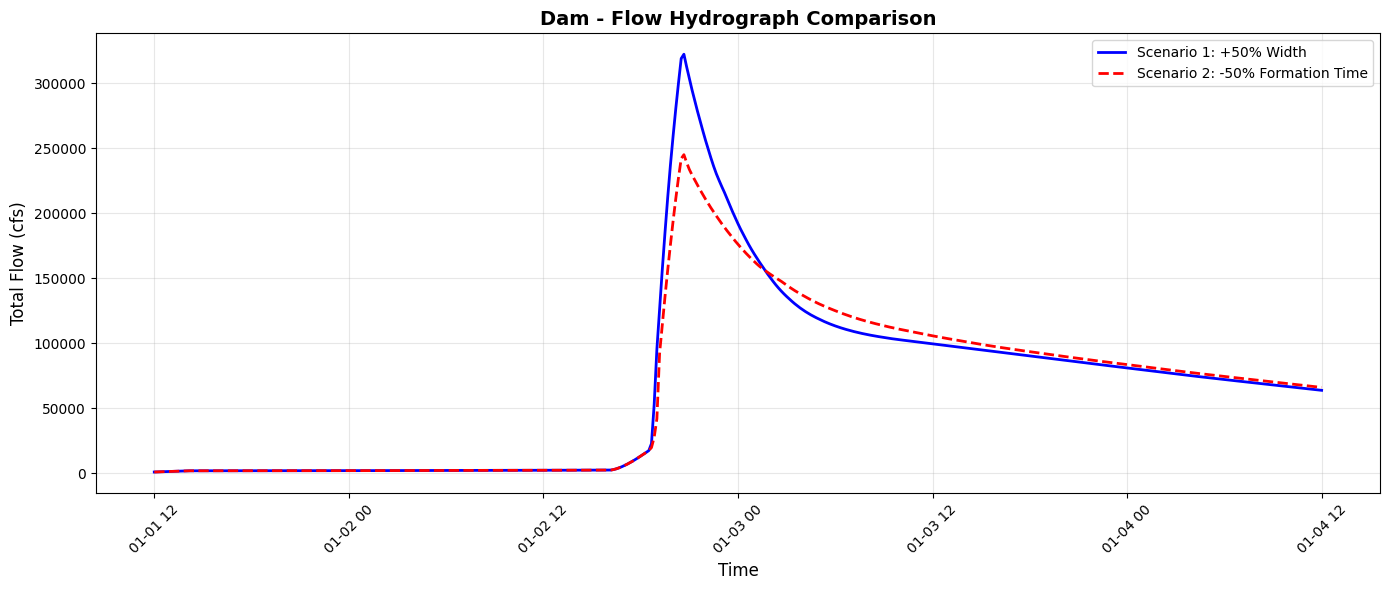

In [30]:
if scenarios:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    linestyles = ['-', '--', '-.', ':', '-']
    
    for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
        color = colors[idx % len(colors)]
        linestyle = linestyles[idx % len(linestyles)]
        
        ax.plot(ts_data['datetime'], ts_data['total_flow'],
               label=scenario_name, color=color, linestyle=linestyle, linewidth=2)
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Total Flow (cfs)', fontsize=12)
    ax.set_title(f'{target_structure} - Flow Hydrograph Comparison', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No scenario data available for comparison")

### 5.2 Peak Flow Comparison (Bar Chart)

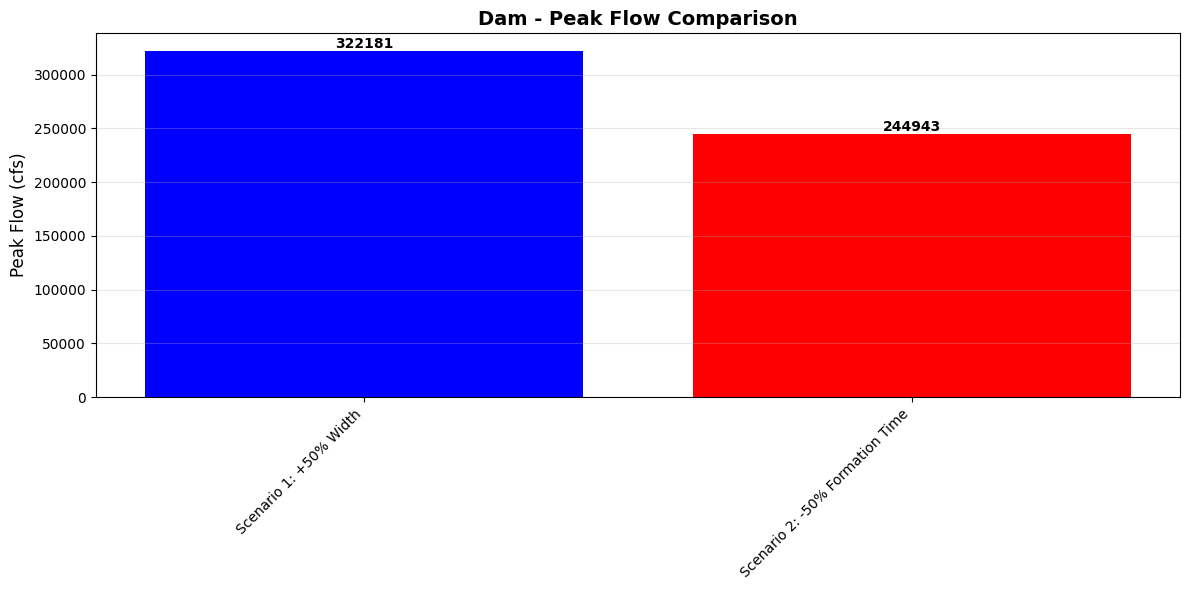


Peak Flow Differences from Baseline:
Scenario 1: +50% Width: 322181 cfs (baseline)
Scenario 2: -50% Formation Time: 244943 cfs (-24.0%)


In [31]:
if summaries:
    # Extract peak flows
    scenario_names = list(summaries.keys())
    peak_flows = [summaries[name].iloc[0]['max_total_flow'] 
                 for name in scenario_names]
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(scenario_names)), peak_flows, 
                  color=['blue', 'red', 'green', 'orange', 'purple'][:len(scenario_names)])
    
    ax.set_xticks(range(len(scenario_names)))
    ax.set_xticklabels(scenario_names, rotation=45, ha='right')
    ax.set_ylabel('Peak Flow (cfs)', fontsize=12)
    ax.set_title(f'{target_structure} - Peak Flow Comparison', 
                fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, peak_flows):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{value:.0f}',
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print percent differences from baseline
    if len(peak_flows) > 1:
        baseline_flow = peak_flows[0]
        print("\nPeak Flow Differences from Baseline:")
        print("=" * 60)
        for i, (name, flow) in enumerate(zip(scenario_names, peak_flows)):
            if i == 0:
                print(f"{name}: {flow:.0f} cfs (baseline)")
            else:
                diff_pct = ((flow - baseline_flow) / baseline_flow) * 100
                print(f"{name}: {flow:.0f} cfs ({diff_pct:+.1f}%)")
else:
    print("No summary data available for comparison")

### 5.3 Breach Width Evolution Comparison

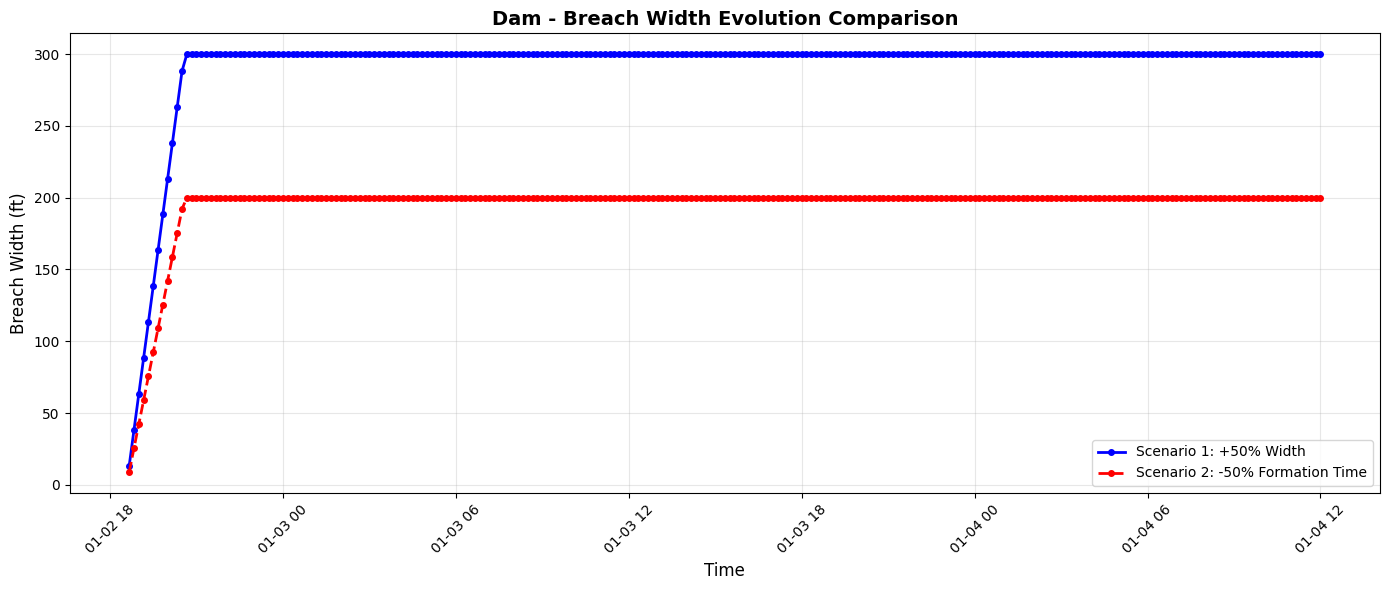

In [32]:
if scenarios:
    # Check if any scenario has breach width data
    has_width_data = any(ts['bottom_width'].notna().any() for ts in scenarios.values())
    
    if has_width_data:
        fig, ax = plt.subplots(figsize=(14, 6))
        
        for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
            if ts_data['bottom_width'].notna().any():
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                
                ax.plot(ts_data['datetime'], ts_data['bottom_width'],
                       label=scenario_name, color=color, linestyle=linestyle, 
                       linewidth=2, marker='o', markersize=4)
        
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Breach Width (ft)', fontsize=12)
        ax.set_title(f'{target_structure} - Breach Width Evolution Comparison', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No breach width data available (breach may not have formed)")
else:
    print("No scenario data available for comparison")

### 5.4 Summary Table Comparison

In [33]:
if summaries:
    # Combine all summaries into a comparison table
    comparison_data = []
    for scenario_name, summary_df in summaries.items():
        row = summary_df.iloc[0].to_dict()
        row['Scenario'] = scenario_name
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Select key columns for display
    display_cols = ['Scenario', 'max_total_flow', 'max_breach_flow', 
                   'final_breach_width', 'final_breach_depth', 
                   'max_hw', 'max_tw']
    
    # Filter to available columns
    display_cols = [col for col in display_cols if col in comparison_df.columns]
    
    print("\nScenario Comparison Summary:")
    print("=" * 100)
    print(comparison_df[display_cols].to_string(index=False))
    
    # Export to CSV
    output_file = project_path / "breach_scenario_comparison.csv"
    comparison_df.to_csv(output_file, index=False)
    print(f"\nComparison table exported to: {output_file}")
else:
    print("No summary data available for comparison table")


Scenario Comparison Summary:
                       Scenario  max_total_flow  max_breach_flow  final_breach_width  final_breach_depth     max_hw     max_tw
         Scenario 1: +50% Width   322181.406250    319811.718750               300.0           18.406982 661.338684 618.665955
Scenario 2: -50% Formation Time   244943.171875    239246.484375               200.0           23.746826 661.606323 615.312927

Comparison table exported to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D\breach_scenario_comparison.csv


### 5.5 Comprehensive Multi-Panel Comparison

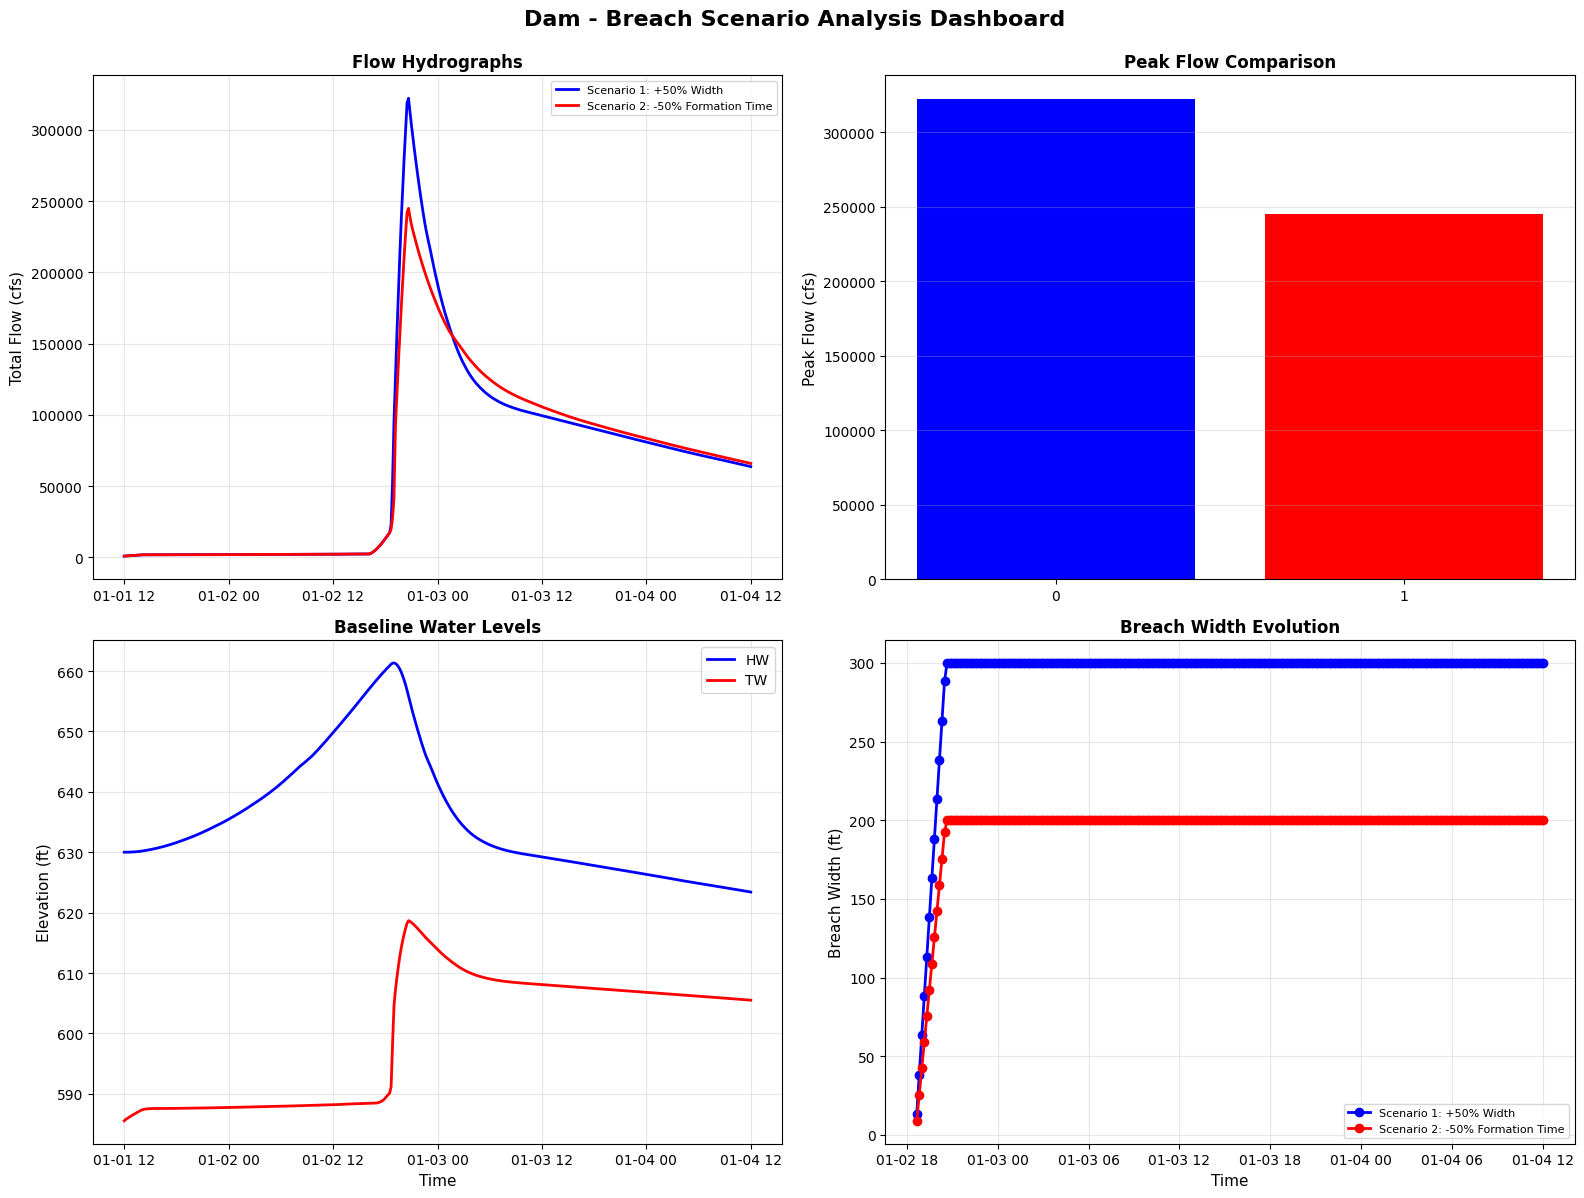

In [34]:
if scenarios and len(scenarios) > 1:
    # Create 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Flow comparison
    for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
        color = colors[idx % len(colors)]
        axes[0, 0].plot(ts_data['datetime'], ts_data['total_flow'],
                       label=scenario_name, color=color, linewidth=2)
    axes[0, 0].set_ylabel('Total Flow (cfs)', fontsize=11)
    axes[0, 0].set_title('Flow Hydrographs', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Peak flows bar chart
    scenario_names = list(summaries.keys())
    peak_flows = [summaries[name].iloc[0]['max_total_flow'] for name in scenario_names]
    bars = axes[0, 1].bar(range(len(scenario_names)), peak_flows,
                          color=colors[:len(scenario_names)])
    axes[0, 1].set_xticks(range(len(scenario_names)))
    axes[0, 1].set_xticklabels(range(len(scenario_names)))
    axes[0, 1].set_ylabel('Peak Flow (cfs)', fontsize=11)
    axes[0, 1].set_title('Peak Flow Comparison', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, axis='y', alpha=0.3)
    
    # Plot 3: HW/TW for baseline
    baseline_ts = scenarios[list(scenarios.keys())[0]]
    axes[1, 0].plot(baseline_ts['datetime'], baseline_ts['hw'], 
                   label='HW', color='blue', linewidth=2)
    axes[1, 0].plot(baseline_ts['datetime'], baseline_ts['tw'], 
                   label='TW', color='red', linewidth=2)
    axes[1, 0].set_xlabel('Time', fontsize=11)
    axes[1, 0].set_ylabel('Elevation (ft)', fontsize=11)
    axes[1, 0].set_title('Baseline Water Levels', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Breach width comparison (if available)
    has_width = False
    for idx, (scenario_name, ts_data) in enumerate(scenarios.items()):
        if ts_data['bottom_width'].notna().any():
            color = colors[idx % len(colors)]
            axes[1, 1].plot(ts_data['datetime'], ts_data['bottom_width'],
                           label=scenario_name, color=color, linewidth=2, marker='o')
            has_width = True
    
    if has_width:
        axes[1, 1].set_xlabel('Time', fontsize=11)
        axes[1, 1].set_ylabel('Breach Width (ft)', fontsize=11)
        axes[1, 1].set_title('Breach Width Evolution', fontsize=12, fontweight='bold')
        axes[1, 1].legend(fontsize=8)
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Breach Width Data',
                       ha='center', va='center', fontsize=14,
                       transform=axes[1, 1].transAxes)
    
    fig.suptitle(f'{target_structure} - Breach Scenario Analysis Dashboard',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("Need at least 2 scenarios for comprehensive comparison")

## 6. Export All Results

In [35]:
if scenarios:
    # Export each scenario's time series
    for scenario_name, ts_data in scenarios.items():
        # Create safe filename
        safe_name = scenario_name.replace(' ', '_').replace(':', '').replace('+', 'plus')
        filename = project_path / f"breach_{safe_name}.csv"
        ts_data.to_csv(filename, index=False)
        print(f"Exported: {filename.name}")
    
    print(f"\nAll scenario data exported to: {project_path}")
else:
    print("No scenario data to export")

Exported: breach_Scenario_1_plus50%_Width.csv
Exported: breach_Scenario_2_-50%_Formation_Time.csv

All scenario data exported to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D


## Summary

This notebook demonstrated:

**✅ Baseline Analysis:**
- Extracted existing breach results from HDF
- Read baseline breach parameters from plan file
- Visualized baseline behavior

**✅ Scenario Creation:**
- Cloned plans to create new scenarios
- Modified breach parameters one at a time:
  - Scenario 1: Increased breach width by 50%
  - Scenario 2: Decreased formation time by 50%

**✅ Results Comparison:**
- Extracted results from all scenarios
- Compared flow hydrographs
- Compared peak flows
- Compared breach geometry evolution
- Created comprehensive comparison dashboard

**✅ Data Export:**
- Exported time series for all scenarios
- Exported comparison summary table

### Key Functions Used:

```python
# HDF Results Extraction (use HdfResultsBreach and HdfStruc)
HdfStruc.list_sa2d_connections(plan)              # List structures in HDF
HdfStruc.get_sa2d_breach_info(plan)               # Get breach capability info
HdfResultsBreach.get_breach_timeseries(plan, structure)   # Extract time series
HdfResultsBreach.get_breach_summary(plan, structure)      # Extract summary stats
HdfResultsBreach.get_breaching_variables(plan, structure) # Breach geometry evolution
HdfResultsBreach.get_structure_variables(plan, structure) # Structure flow variables

# Plan File Parameter Management (use RasBreach)
RasBreach.list_breach_structures_plan(plan)      # List structures in plan file
RasBreach.read_breach_block(plan, structure)     # Read parameters
RasBreach.update_breach_block(plan, structure, geom_values=[...])  # Modify parameters
```

### Architectural Pattern:

**ras-commander separates HDF and plain text operations:**
- **RasBreach** → Breach PARAMETERS in plan files (.p##)
- **HdfResultsBreach** → Breach RESULTS from HDF files (.p##.hdf)
- **HdfStruc** → Structure listings and metadata from HDF

**Important:** Use plan file methods for parameter operations to ensure structure names match!

### Breach Geom Field Structure:
```python
# Breach Geom CSV format (10 fields):
[0] Centerline/Station     # ft
[1] Initial Bottom Width   # ft
[2] Final Bottom Elevation # ft  <-- Example: change this to 605
[3] Left Side Slope        # H:V ratio
[4] Right Side Slope       # H:V ratio
[5] Active Flag            # True/False
[6] Weir Coefficient       # dimensionless
[7] Top Elevation          # ft
[8] Formation Method       # 1=Time, 2=Trigger
[9] Formation Time/Threshold # hrs or ft

# Example: Update Final Bottom Elevation
new_geom = baseline_geom.copy()
new_geom[2] = 605  # Set to 605 ft
RasBreach.update_breach_block("template_plan", "Dam", geom_values=new_geom)
```